In [18]:
import matplotlib.pyplot as plt

from utils import *
import jax.numpy as np

from optimize import *
from regression import LogisticRegression

import math

# Plotting code

Use the below function to show your line plots.

`all_data` is expected to be a list of experiments, each experiment containing:
1. "validation_loss": the validation loss at each step.
2. "label": a label for the experiment

In [19]:
def plot_superimposed_line_series(all_data, classification_problem):
    for series in all_data:
        plt.plot(series['validation_loss'], label = series['label'])   
    #
    plt.xlabel('Optimization step')
    plt.ylabel('Validation NLL')
    plt.ylim(0, 1.5)
    plt.title('A comparison of stochastic gradient methods for '+classification_problem)
    plt.legend()
#

In [20]:
def gather_data(X_train, Y_train, X_val, Y_val, label_0, label_1):
    train_query = np.logical_or(Y_train==label_0, Y_train==label_1)
    val_query = np.logical_or(Y_val==label_0, Y_val==label_1)

    Y_train_query = Y_train[train_query]
    Y_train_mapped = np.where(Y_train_query == label_0, np.zeros(Y_train_query.shape[0]), np.ones(Y_train_query.shape[0]))

    Y_val_query = Y_val[val_query]
    Y_val_mapped = np.where(Y_val_query == label_0, np.zeros(Y_val_query.shape[0]), np.ones(Y_val_query.shape[0]))

    return X_train[train_query], Y_train_mapped, X_val[val_query], Y_val_mapped
#

In [21]:
dataset = 'cifar10'
X_train_all = np.load('X_'+dataset+'_train.npy')
Y_train_all = np.load('Y_'+dataset+'_train.npy')
X_val_all = np.load('X_'+dataset+'_val.npy')
Y_val_all = np.load('Y_'+dataset+'_val.npy')

cifar10_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
label_to_ind = dict([(cifar10_labels[i], i) for i in range(len(cifar10_labels))])

# The Superman split: birds vs. airplanes

In [22]:
# put all the plots separately and both, look at website for more instruction 

# Let's consider the Superman split: birds vs. airplanes
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['bird'], label_to_ind['airplane'])

N = X_train.shape[0]
D = X_train.shape[1]

# number of optimization steps
T = 2**15

# fix the seed
seed = 0

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * SGD (constant): step size is .2/L
# * SGD (diminishing): starting step size is 2/L, ending step size is 1e-2/L
# * SAGA (constant): step size is .1/L
# * SGD w/ momentum (diminishing): starting step size is 2/L, ending step size is 1e-2/L

lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 1e-1)

init_prng(seed)

Array([0, 0], dtype=uint32)

Running Constant step size SGD


Optimizing: 100%|██████████| 32768/32768 [03:47<00:00, 143.98it/s, Loss=0.6103, Step size=0.0000, Update mag=0.0001]


Optimization completed. Final loss: 0.6103
Validation accuracy: 0.2540


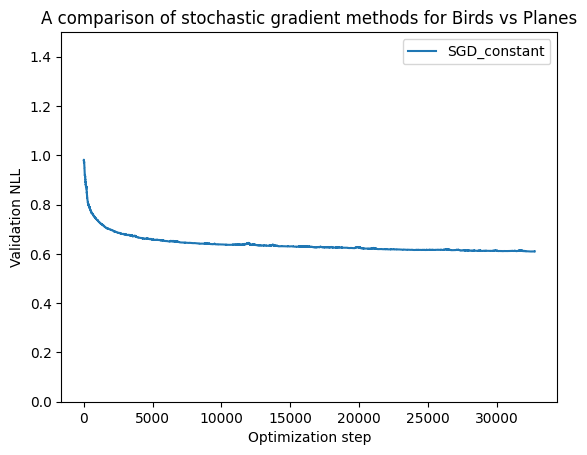

In [23]:
# Constant step size SGD
print("Running Constant step size SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = constant_step_size(20/L)
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment1 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SGD_constant"
}

all_data = [experiment1]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")


Running Constant step size SGD


Optimizing: 100%|██████████| 32768/32768 [03:57<00:00, 137.90it/s, Loss=0.6041, Step size=0.0000, Update mag=0.0000]


Optimization completed. Final loss: 0.6041
Validation accuracy: 0.2565


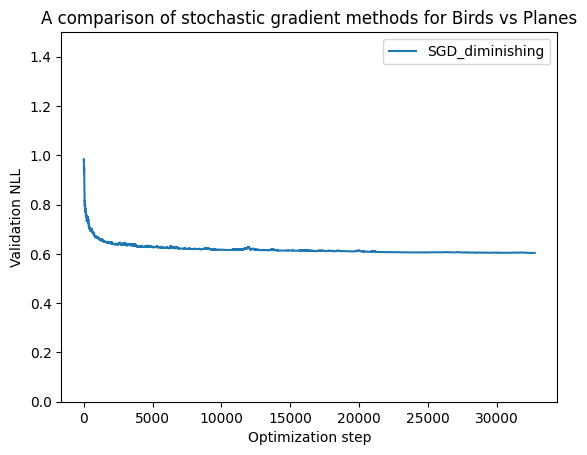

In [24]:
# Diminishing step size SGD
print("Running Constant step size SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = diminishing_step_size(100/L, 10/L, T)
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment2 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SGD_diminishing"
}

all_data = [experiment2]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")




Running SAGA constant
Initializing SAGA with gradients for all training data
Running optimization


Optimizing: 100%|██████████| 32768/32768 [07:22<00:00, 74.14it/s, Loss=0.6088, Step size=0.0000, Update mag=0.0000]


Optimization completed. Final loss: 0.6088
Validation accuracy: 0.2548


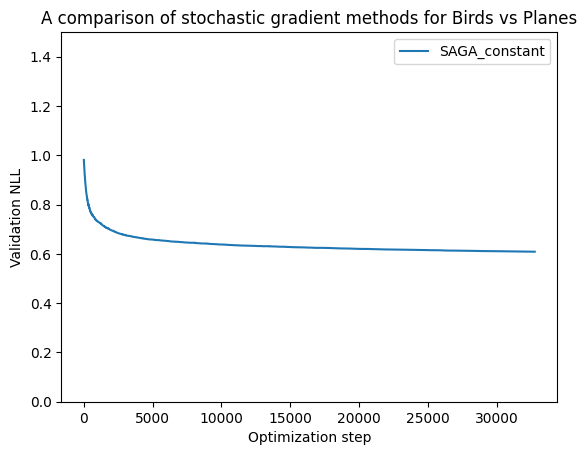

In [25]:
# SAGA constant
print("Running SAGA constant")
w0 = lr.initialization()

# Initialize SAGA with gradients for all training data
print(f"Initializing SAGA with gradients for all training data")
all_gradients = [lr.train_loss_and_grad(w0, [i])[1] for i in range(N)]
saga_update = saga(all_gradients)

data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = constant_step_size(20/L)
update_method = saga_update

print(f"Running optimization")
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment3 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SAGA_constant"
}

all_data = [experiment3]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")

Running diminishing step size SGD with momentum


Optimizing: 100%|██████████| 32768/32768 [03:27<00:00, 157.79it/s, Loss=0.5558, Step size=0.0000, Update mag=0.0003]


Optimization completed. Final loss: 0.5558
Validation accuracy: 0.2598


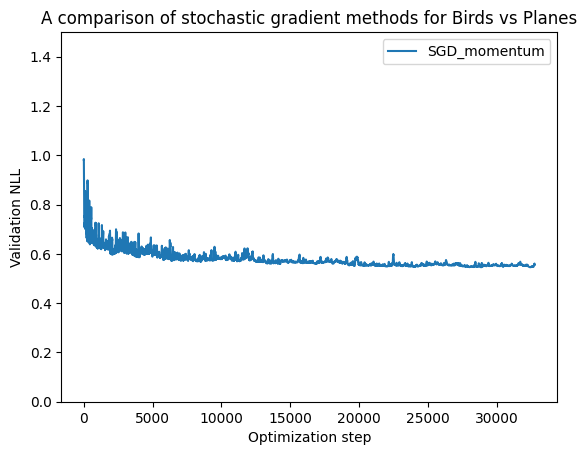

In [26]:
# Diminishing step size SGD with momentum
print("Running diminishing step size SGD with momentum")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = diminishing_step_size(100/L, 10/L, T)
update_method = gd_with_momentum(0.9, D+1)
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment4 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SGD_momentum"
}

all_data = [experiment4]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Birds vs Planes")




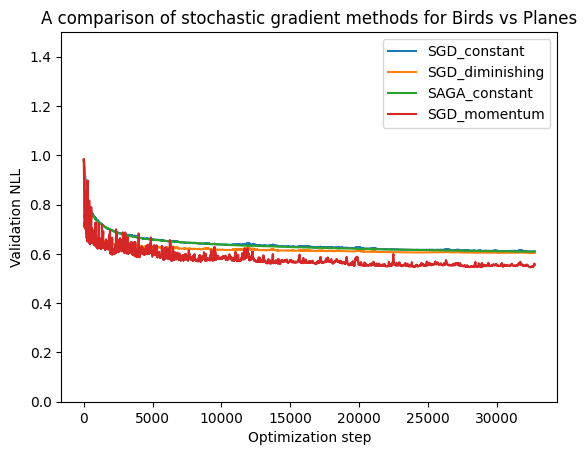

In [27]:
# show the aggregated plot
all_data = [experiment1, experiment2, experiment3, experiment4]
plot_superimposed_line_series(all_data, "Birds vs Planes")

### Results and Discussion 

| Experiment Name            | Validation Acc |
|----------------------------|----------------|
| SGD Constant Step Size     | 0.2540         |
| SGD Diminishing Step Size  | 0.2565         |
| SAGA Constant Step Size    | 0.2548         |
| SGD Momentum               | 0.2598         |

# Deer vs. horses

In [28]:
# Now we will consider deers vs. horses
X_train, Y_train, X_val, Y_val = gather_data(X_train_all, Y_train_all, X_val_all, Y_val_all, label_to_ind['deer'], label_to_ind['horse'])

N = X_train.shape[0]
D = X_train.shape[1]

# number of optimization steps
T = 2**15

# fix the seed
seed = 0

# run optimization below, with step sizes set to (L = Lipschitz constant):
# * SGD (constant): step size is .2/L
# * SGD (diminishing): starting step size is 2/L, ending step size is 1e-2/L
# * SAGA (constant): step size is .1/L
# * SGD w/ momentum (diminishing): starting step size is 2/L, ending step size is 1e-2/L

lr = LogisticRegression(X_train, Y_train, X_val, Y_val, beta = 1e-1)

init_prng(seed)

Array([0, 0], dtype=uint32)

Running Constant step size SGD


Optimizing: 100%|██████████| 32768/32768 [03:30<00:00, 155.75it/s, Loss=0.6851, Step size=0.0000, Update mag=0.0008]


Optimization completed. Final loss: 0.6851
Validation accuracy: 0.2270


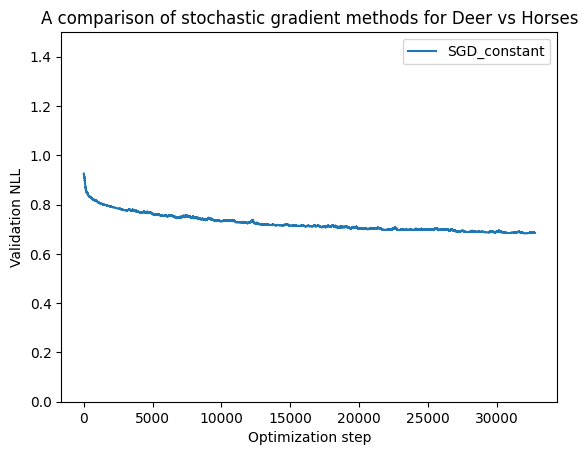

In [29]:
# Constant step size SGD
print("Running Constant step size SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = constant_step_size(20/L)
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment1 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SGD_constant"
}

all_data = [experiment1]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")


Running Constant step size SGD


Optimizing: 100%|██████████| 32768/32768 [03:36<00:00, 151.12it/s, Loss=0.6748, Step size=0.0000, Update mag=0.0004]


Optimization completed. Final loss: 0.6748
Validation accuracy: 0.2293


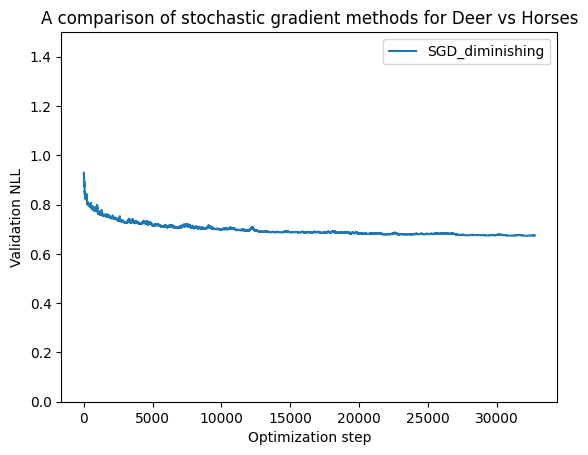

In [30]:
# Diminishing step size SGD
print("Running Constant step size SGD")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = diminishing_step_size(100/L, 10/L, T)
update_method = gd()
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment2 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SGD_diminishing"
}

all_data = [experiment2]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")




Running SAGA constant
Initializing SAGA with gradients for all training data
Running optimization


Optimizing: 100%|██████████| 32768/32768 [05:38<00:00, 96.81it/s, Loss=0.6832, Step size=0.0000, Update mag=0.0000] 


Optimization completed. Final loss: 0.6832
Validation accuracy: 0.2272


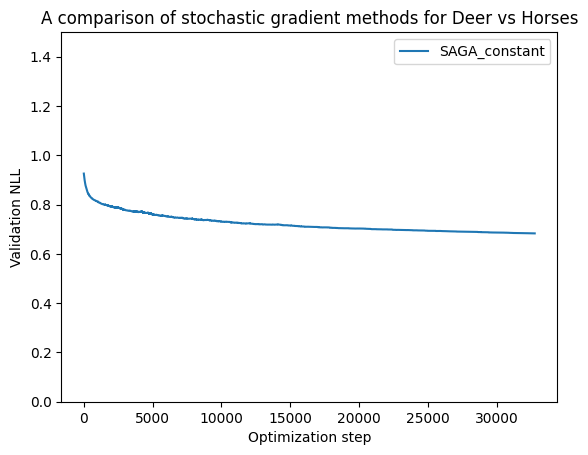

In [31]:
# SAGA constant
print("Running SAGA constant")
w0 = lr.initialization()

# Initialize SAGA with gradients for all training data
print(f"Initializing SAGA with gradients for all training data")
all_gradients = [lr.train_loss_and_grad(w0, [i])[1] for i in range(N)]
saga_update = saga(all_gradients)

data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = constant_step_size(20/L)
update_method = saga_update

print(f"Running optimization")
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment3 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SAGA_constant"
}

all_data = [experiment3]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")

Running diminishing step size SGD with momentum


Optimizing: 100%|██████████| 32768/32768 [03:36<00:00, 151.35it/s, Loss=0.6190, Step size=0.0000, Update mag=0.0008]


Optimization completed. Final loss: 0.6190
Validation accuracy: 0.2378


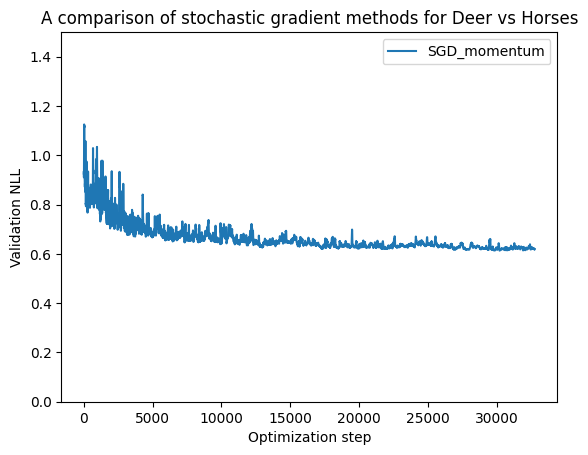

In [32]:
# Diminishing step size SGD with momentum
print("Running diminishing step size SGD with momentum")
w0 = lr.initialization()
data_sampler = minibatch_sampler(N, 1)
loss_func = lr.validation_loss
descent_func = lambda w, data_samples: lr.train_loss_and_grad(w, data_samples)[1]
L = lr.lipschitz_constant() 
step_size = diminishing_step_size(100/L, 10/L, T)
update_method = gd_with_momentum(0.9, D+1)
wF, losses = optimize(w0, data_sampler, loss_func, descent_func, step_size, update_method, T, verbose=True)
steps = list(1 * np.arange(0, T))

experiment4 = {
    "steps": steps,
    "validation_loss": losses,
    "label": "SGD_momentum"
}

all_data = [experiment4]
print(f"Validation accuracy: {lr.validation_accuracy(wF):.4f}")
plot_superimposed_line_series(all_data, "Deer vs Horses")


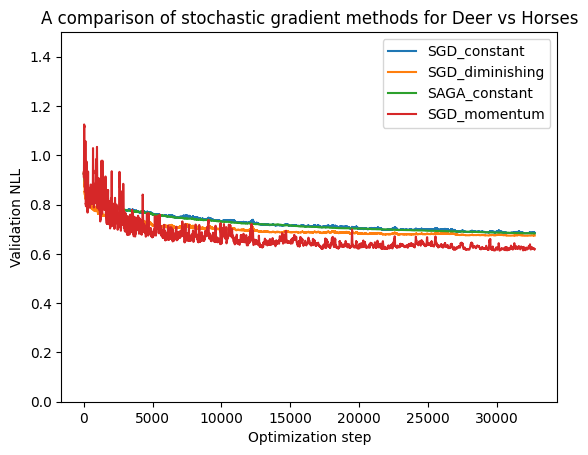

In [33]:
# show the aggregated plot
all_data = [experiment1, experiment2, experiment3, experiment4]
plot_superimposed_line_series(all_data, "Deer vs Horses")

### Results and Discussion 

| Experiment Name            | Validation Acc |
|----------------------------|----------------|
| SGD Constant Step Size     | 0.2270         |
| SGD Diminishing Step Size  | 0.2293         |
| SAGA Constant Step Size    | 0.2272         |
| SGD Momentum               | 0.2378         |

### Discussion

Upon examination of the aggregate plots across all experimental runs, we observe a notable similarity in the performance of Stochastic Gradient Descent (SGD) and SAGA when utilizing a constant step size. The training loss trajectories for both algorithms exhibit a high degree of similarity, with their respective curves largely overlapping. It is worth noting that both these optimization methods, when implemented with a constant learning rate, demonstrate inferior performance compared to SGD variants employing more sophisticated learning rate strategies, such as diminishing learning rate schedules or momentum-based approaches.